# Gyro bias stability

This notebook investigates the stability of the gyro bias.  This is prompted in particular by the
NSM transition on 2016:324 which is believed to have been caused by a gyro bias excursion during
a maneuver.

The main part of this notebook looks at integrated gyro bias errors in a way similar to the [Analyzing Gyro Bias Jog Risks](https://github.com/sot/gyro_bias/blob/master/sig_bias_jogs/sig_bias_jog_stats.ipynb) notebook that
Amanda Arvai developed in 2014.  Key differences are:
- Analysis uses 1-minute bins instead of 5-minute bins.  This requires preprocessing full resolution data
  and generating an associated on-disk data cache.  Anyone wishing to replicate this analysis should contact TLA to
  get the existing data file (~50 Mb), or regenerate in less than an hour.
- Emphasis on time-history plots instead of histogram statistics.
- Roll, pitch, and yaw are treated separately instead of a single RSS'd value.
- Uses sliding-box (overlapping) windows instead of unique windows.

### Summary

#### Rapid (5-minute) variability
- Just prior to the 2016:324 NSM there was a significant and very rapid change in
  roll bias: 0.04 arcsec/sec in << 5 minutes.  Most likely the observed change is
  entirely limited by the Kalman filter response.
- Analysis ala Bill Davis that uses raw data without the Kalman filter might be useful.
- Similar changes were seen twice before:
  - 2016:234 - before failed maneuver acquisition leading to BSH (*evidence for large pitch variation*)
  - 2016:200 - no consequence (*no evidence for pitch variation*).

#### Slower (30-45 minute) variability
- Results and analysis need discussion within community.
- Not clear if the recent acquisition failure events are consistent with this analysis.
- The events clearly happened, implying our (my) understanding is incomplete.


In [1]:
from __future__ import division
from Chandra.Maneuver import attitudes, inject_errors, get_quaternions
from Quaternion import Quat
from Ska.engarchive import fetch_eng as fetch
from Ska.Matplotlib import plot_cxctime
from kadi import events
from Ska.Numpy import interpolate
from astropy.table import Table
import matplotlib.pyplot as plt
from Chandra.Time import DateTime

import shelve
from itertools import izip

%matplotlib inline

In [2]:
def gbias_2016324(gyro, label):
    dat = fetch.Msid('aogbias{}'.format(gyro), '2016:324:12:00:00', '2016:324:13:00:00')
    plot_cxctime(dat.times, np.degrees(dat.vals) * 3600)
    plt.grid();
    plt.ylabel('Bias (arcsec/sec)')
    y0, y1 = plt.ylim()
    ym = (y0 + y1) / 2
    if (y1 - y0) < 0.06:
        y1 = ym + 0.03
        y0 = ym - 0.03
        plt.ylim(y0, y1)
    plt.title('{} bias before maneuver before NSM'.format(label))
    plt.tight_layout();

### Look at the gyro biases just before maneuver before 2016:324 NSM

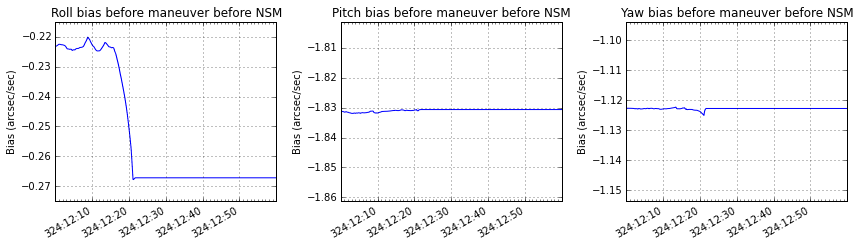

In [3]:
plt.figure(figsize=(12, 3.5))
for idx, label in ((1, 'Roll'), (2, 'Pitch'), (3, 'Yaw')):
    plt.subplot(1, 3, idx)
    gbias_2016324(idx, label)

In [4]:
def get_dwell_intervals(start, stop):
    """
    Get NPM dwells.  Allow dwells immediately prior to NSM or SSM.
    """
    dwells = (events.dwells(pad=(-1200, 0)) 
              & ~events.safe_suns(pad=(-300, 24 * 3600))
              & ~events.normal_suns(pad=(-300, 24 * 3600)))
    return dwells.intervals(start, stop)

In [5]:
def get_binned_bias(start, stop):
    """
    Get gyro bias values between ``start`` and ``stop`` binned to 1 minute chunks.
    """
    dats = []
    for gyro in (1, 2, 3):
        dat = fetch.Msid('aogbias{}'.format(gyro), start, stop)
        vals = np.degrees(dat.vals)* 3600
        t = Table([np.trunc(dat.times / 60), vals], names=('minutes', 'val'))
        tg = t.group_by('minutes')
        tga = tg.groups.aggregate(np.mean)
        dats.append(tga['val'])
        
    try:
        dats = np.array(dats)
    except Exception as err:
        print('size mismatch at {} {}'.format(start, err))
    
    return dats

In [6]:
def bias_variability(bias, delta_mins=30, integrate=True):
    """
    Get running estimate of bias variability, either as a difference between
    samples separated by ``delta_mins`` (integrate=False) or as the integral
    of ``delta_mins`` of samples (after subtracting the value of the first
    sample in the span).

    :param bias: 3 x N array of bias values [arcsec/sec] sampled at 1 minute intervals
    :param delta_mins: difference or integration interval [minutes]
    :param integrate: perform difference or integration

    :returns: bias variability (3 x N array), either arcsec/sec (integrate=False) or arcsec
    """

    # Integrate between x0, x1 of (y - y(t0)) = Int(y) - (t1-t0) * y(t0)
    # dt = 1 (minute) here, but bias is arcsec/sec, so mult by 60 later
    # to get arcsec.
    if integrate:
        bias_sum = np.cumsum(bias, axis=1)
        bias_sum_var = (bias_sum[:, delta_mins:] - bias_sum[:, :-delta_mins] 
                        - delta_mins * bias[:, :-delta_mins])
        bias_var = bias_sum_var * 60
    else:
        bias_var = bias[:, delta_mins:] - bias[:, :-delta_mins]

    return bias_var

In [7]:
def plot_bias_var(bias_var):
    plt.hist(bias_var, alpha=0.5, log=True, bins=20);
    plt.ylim(0.5, 1e5);

In [8]:
# Define overall data sample

START = '2014:001'
STOP = '2017:001'

In [9]:
dwells = get_dwell_intervals(START, STOP)

In [10]:
# Make a disk data file with bias data for every dwell in the data sample.
# This is a keyed data store so it is easy to add new dwells as they become available.

def update_biases_shelf(dwells):
    biases = shelve.open('biases.shelve', protocol=-1)

    dwls = (dwell for dwell in dwells if dwell[0] not in biases)
    for i, dwell in enumerate(dwls):
        start, stop = dwell
        if i % 100 == 0:
            print(start)
        biases[start] = get_binned_bias(start, stop)

    biases.close()

In [11]:
update_biases_shelf(dwells)

In [12]:
# Read all the dwells into memory
biases = dict(shelve.open('biases.shelve', protocol=-1).items())

## Bias variability on 5 minute time scales

Investigate bias variability on the very short time scale of 5 minutes seen just before last maneuver before 2016:324 NSM.  

Is there precedent?  Answer: yes, twice before.  Once of those resulted in 2016:234 BSH.

In [13]:
def get_bias_vars_times(biases, integrate=False, delta_mins=5, unique_times=False):
    bias_vars_list = [bias_variability(bias, integrate=integrate, delta_mins=delta_mins) 
                     for bias in biases.values()]
    bias_vars = np.hstack(bias_vars_list)

    times = DateTime(biases.keys()).secs
    times_list = []
    for time, bias_var in izip(times, bias_vars_list):
        if unique_times:
            ts = time + 60 * np.arange(len(bias_var[0]))
        else:
            ts = np.repeat(time, len(bias_var[0]))  # one time stamp per dwell
        times_list.append(ts)

    times = np.hstack(times_list)
    
    return bias_vars, times

In [14]:
bias_vars, times = get_bias_vars_times(biases, delta_mins=5, unique_times=False)

In [15]:
def plot_delta_bias(bias_vars, times, min_delta=0.005, dt_label='5'):
    plt.figure(figsize=(14, 3.5))
    for idx, label in enumerate(('Roll', 'Pitch', 'Yaw')):
        bv = bias_vars[idx]
        ok = np.abs(bv) > min_delta  # select only outliers
        if idx == 0:
            ax0 = plt.subplot(1, 3, idx + 1)
        else:
            plt.subplot(1, 3, idx + 1, sharex=ax0, sharey=ax0)
        if np.any(ok):
            plot_cxctime(times[ok], bv[ok], '.')
        plt.grid()
        plt.ylabel('Delta bias (arcsec/sec)')
        plt.title('{} {}-minute delta bias'.format(label, dt_label))
        plt.margins(0.05)
        plt.tight_layout();

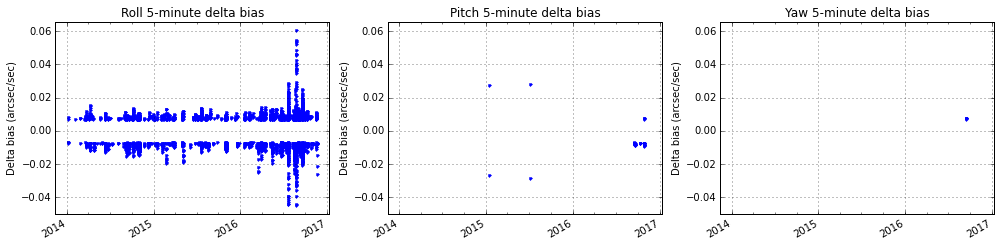

In [16]:
plot_delta_bias(bias_vars, times, min_delta=0.007)

In [17]:
print(DateTime(np.unique(times[np.where(np.abs(bias_vars[0]) > 0.04)])).date)

['2016:200:03:45:58.961' '2016:234:04:56:06.530']


### Corresponding daily plots

- [Day 200 gyro bias plots](http://occweb.cfa.harvard.edu/occweb/FOT/engineering/reports/dailies/2016/JUL/jul18_200/A_GYRO_BIAS_24HR.html)
- [Day 234 gyro bias plots](http://occweb.cfa.harvard.edu/occweb/FOT/engineering/reports/dailies/2016/AUG/aug21_234/A_GYRO_BIAS_24HR.html)

## 30-minute integrated bias variation

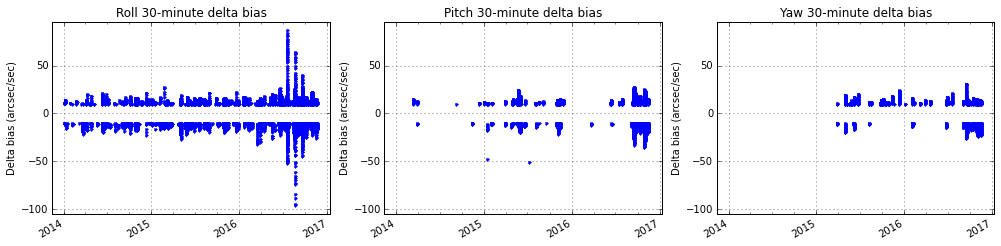

In [18]:
delta_mins = 30
bias_vars, times = get_bias_vars_times(biases, delta_mins=delta_mins, integrate=True)
plot_delta_bias(bias_vars, times, min_delta=10, dt_label=delta_mins)

In [19]:
print(DateTime(np.unique(times[np.where(np.abs(bias_vars[0]) > 50)])).date)
print(DateTime(np.unique(times[np.where(np.abs(bias_vars[1]) > 50)])).date)
print(DateTime(np.unique(times[np.where(np.abs(bias_vars[2]) > 50)])).date)

['2016:200:03:45:58.961' '2016:234:04:56:06.530']
['2015:187:21:06:27.235']
[]


In [20]:
def print_stats(bias_vars, times):
    ok = times > DateTime('2016:200').secs
    bok = bias_vars[:, ok]
    ok = np.abs(bok) > 50  # arcsec
    print('Expected error > 50 arcsec events per 1000 large maneuvers')
    print('Roll  {:.3f}'.format(1000 * np.count_nonzero(ok[0]) / ok.shape[1]))
    print('Pitch {:.3f}'.format(1000 * np.count_nonzero(ok[1]) / ok.shape[1]))
    print('Yaw   {:.3f}'.format(1000 * np.count_nonzero(ok[2]) / ok.shape[1]))

In [21]:
print_stats(bias_vars, times)

Expected error > 50 arcsec events per 1000 large maneuvers
Roll  0.154
Pitch 0.000
Yaw   0.000


## 45 minute integrated bias variation

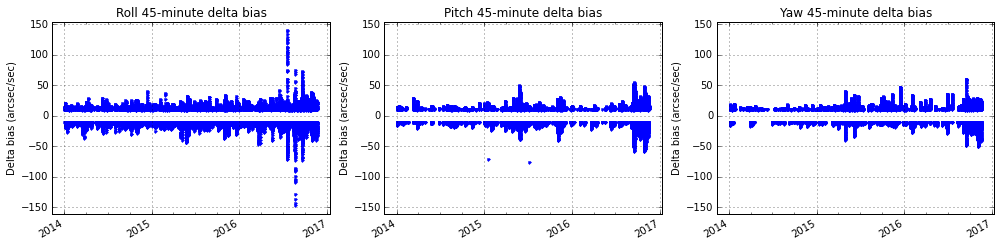

In [22]:
delta_mins = 45
bias_vars, times = get_bias_vars_times(biases, delta_mins=delta_mins, integrate=True, unique_times=True)
plot_delta_bias(bias_vars, times, min_delta=10, dt_label=delta_mins)

In [23]:
print(DateTime(np.unique(times[np.where(np.abs(bias_vars[0]) > 50)])).date)
print(DateTime(np.unique(times[np.where(np.abs(bias_vars[1]) > 50)])).date)
print(DateTime(np.unique(times[np.where(np.abs(bias_vars[2]) > 50)])).date)

['2016:200:03:52:58.961' '2016:200:03:53:58.961' '2016:200:03:54:58.961'
 '2016:200:03:55:58.961' '2016:200:03:56:58.961' '2016:200:03:57:58.961'
 '2016:200:03:58:58.961' '2016:200:03:59:58.961' '2016:200:04:00:58.961'
 '2016:200:04:01:58.961' '2016:200:04:08:58.961' '2016:200:04:09:58.961'
 '2016:200:04:10:58.961' '2016:200:04:11:58.961' '2016:200:04:12:58.961'
 '2016:200:04:13:58.961' '2016:200:04:19:58.961' '2016:200:04:20:58.961'
 '2016:200:04:21:58.961' '2016:200:04:22:58.961' '2016:200:04:23:58.961'
 '2016:200:04:24:58.961' '2016:200:04:25:58.961' '2016:200:04:26:58.961'
 '2016:200:04:27:58.961' '2016:200:04:28:58.961' '2016:200:04:29:58.961'
 '2016:200:04:30:58.961' '2016:200:04:31:58.961' '2016:200:04:42:58.961'
 '2016:200:04:43:58.961' '2016:200:04:44:58.961' '2016:200:04:45:58.961'
 '2016:200:04:46:58.961' '2016:200:04:47:58.961' '2016:200:04:48:58.961'
 '2016:200:04:49:58.961' '2016:200:04:50:58.961' '2016:200:04:51:58.961'
 '2016:200:04:52:58.961' '2016:200:05:16:58.961' '2

In [24]:
print_stats(bias_vars, times)

Expected error > 50 arcsec events per 1000 large maneuvers
Roll  0.536
Pitch 0.460
Yaw   0.100
